# Detection of changes in the exploitation cycles of alluvial mining activity in the Peruvian Amazon using deep learning, cloud computing and satellite imagery.

This work is distributed under the MIT license
    
```
MIT License

Copyright (c) 2023 Marvin Quispe - Conservación Amazónica (ACCA) - SERVIR Amazonia

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

contact: marvinjqs@gmail.com / https://github.com/marvinjqs
```



# Content

# 1. Library import and authentication

The colab environment comes with several data science packages pre-installed. We can know the libraries installed in our current project by executing the following code.

In [ ]:
!pip list

The first step is to authenticate our Google Cloud Platform (GCP) credentials. This will allow us to access the GCP project we will be working on.

In [2]:
from google.colab import auth
auth.authenticate_user()

The first step is to authenticate our Google Cloud Platform credentials. This will allow us to access the GCP project we will be working on. Then, we will activate our project in the current colab session and print out a list of all the projects we have access to.

In [3]:
project_id = 'deeplearning-306718'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://logging-dataset/
gs://logging-roads-dataset/
gs://mining-infrastructure-dataset/
gs://mining-ponds-dataset/
gs://mining-ponds-dataset-v2/
gs://mining-rafts/
gs://modis-suomi/
gs://nicfi/
gs://rtc-asf/
gs://s5p/
gs://skysat-acca/


Now we will import the Google Earth Engine (GEE) library in python. In addition, we can configure our Earth Engine API with the *High-volume Endpoint* option to have more simultaneous requests when we need to download data.  See the [following section](https://developers.google.com/earth-engine/cloud/highvolume) for more info.

In [4]:
import ee
import google

ee.Authenticate()
ee.Initialize()

#credentials, _ = google.auth.default()
#ee.Initialize(credentials, project=project_id,  opt_url='https://earthengine-highvolume.googleapis.com')

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=5hyEBJ5orIxAd4Yw8fqt_KE8xG5G7XFJiHJFvuAMQWs&tc=HdXflNzziKczudKAMWRB3oZsfrMOcnx_JxKDAl7VR70&cc=abbKaO6Qk8nzINuY2HvlWaJLt3LINOTc_9rYdT8mKk8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXkf-3GjftOttM0gW2EhEtL7TowRpDs9AJYNh1gX0epr_g93tzaxSJI

Successfully saved authorization token.


We will also authenticate the credentials to our Google Drive to be able to save or read files stored there.

In [5]:
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


To finish with this part, we need to import all the libraries that we will use in our workflow. In case some libraries are not installed by default in Colab, you need to install them using:
```
!pip install [package-name].
```

In [6]:
import io
import numpy as np
import pandas as pd
import geemap.foliumap
import tensorflow as tf
import keras
import google
import time

from matplotlib import pyplot as plt
from numpy.lib import recfunctions as rfn
from concurrent.futures import ThreadPoolExecutor
from tensorflow.python.lib.io import file_io
from io import BytesIO
from datetime import datetime

# 2. Data exploration

Once we have all the libraries and credentials loaded in our Colab session, we will visualize and explore the vector data we digitized to train, validate and test our model.

In [7]:
# Import Training data from GEE Asset and show on Map
data = ee.FeatureCollection('users/MarvinQuispe/BBDD_PozasMineras_LaPampa_2023');

# filter mining ponds
active_mining = data.filter(ee.Filter.eq('type','Mineria_Activa'))
inactive_mining = data.filter(ee.Filter.eq('type','Mineria_Inactiva'))

# zoom in Madre de Dios, La Pampa
Map = geemap.Map(center=[-12.995, -69.942], zoom= 13, basemap='Esri.WorldImagery')

# add the mining ponds digitalization to the map
Map.addLayer(active_mining, {'color': 'yellow'},"Active mining");
Map.addLayer(inactive_mining, {'color': 'green'},"Inactive mining");
Map

Map(center=[-12.995, -69.942], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

We will create a list with the IDs of the satellite images that were used for the creation of the Benchmark data.

In [8]:
# Sentinel 2 Collection
sentinel_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

# List of images to obtain the patches
image_list = data.aggregate_array('imgID').distinct().getInfo()

# Print list
print('Image list - ID: ', image_list)

Image list - ID:  ['20230802T145731_20230802T150413_T19LCF']


We can also calculate the number of polygons/patches to use in each stage of the model.

In [9]:
data = ee.FeatureCollection('users/MarvinQuispe/BBDD_PozasMineras_LaPampa_2023')
data_fc_random = data.randomColumn()

training = data_fc_random.filter(ee.Filter.lt('random', 0.7))
validation = data_fc_random.filter(ee.Filter.gte('random', 0.7)).filter(ee.Filter.lt('random', 0.9))
testing = data_fc_random.filter(ee.Filter.gte('random', 0.9))

print('Data total: ', data.size().getInfo())
print('Training: ', training.size().getInfo())
print('Validation: ', validation.size().getInfo())
print('Testing: ', testing.size().getInfo())

Data total:  590
Training:  391
Validation:  126
Testing:  73


# 3. Image processing and benchmark data extraction with GEE

## 3.1. Normalization (Feature scaling)

Normalizing the bands of a satellite image helps to ensure that all bands have the same scale and range. This is important in a Deep Learning model to ensure that it learns correctly and does not give more importance to the variable with the largest range.

$x_{normalized} = \frac{(x - min(x))*(b-a)}{max(x) - min(x)} + a$

See the [following section](https://atoti.io/articles/when-to-perform-a-feature-scaling/) for more info.

In [10]:
# Function to normalize the bands of an image
def normalize_image(image, bands, min_value, max_value, scale):
  # Obtain min and max values
  min_val = ee.Number(min_value)
  max_val = ee.Number(max_value)

  # Get a reducer that calculates the minimum and maximum of a band.
  band_stats = image.select(bands).reduceRegion(
      reducer=ee.Reducer.minMax(),
      geometry=image.geometry(),
      scale=scale,
      crs=image.select(0).projection(),
      maxPixels=1e13
      )

  def normalize_band(band):
    # Select the band
    selected_band = image.select(band)

    # Get the min and max of the current band
    band_min = ee.Number(band_stats.get(ee.String(band).cat(ee.String('_min'))))
    band_max = ee.Number(band_stats.get(ee.String(band).cat(ee.String('_max'))))

    # Normalize the band
    normalized_band = ((selected_band.subtract(band_min)
                        .multiply(max_val.subtract(min_val)
                        .divide(band_max.subtract(band_min)))
                        .add(min_val))
                        .rename(ee.String(band).cat(ee.String('_normalized'))))

    return normalized_band.toFloat()

  # Normalize each band and add it to the image
  normalized_bands = [normalize_band(b) for b in bands]
  normalized_image = image.addBands(normalized_bands)

  return normalized_image

## 3.2. Spectral indices

Spectral indices are mathematical equations whose variables are the pixel values of some bands of interest. They allow us to identify and highlight some specific features in our area of interest. Example: Water bodies, vegetation, snow, etc. See the [following section](https://www.nv5geospatialsoftware.com/docs/AlphabeticalListSpectralIndices.html) for more info.

In [11]:
# NDVI
def add_NDVI(img):
  ndvi = img.expression(
      '(NIR - RED) / (NIR + RED)', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')
      }
  ).rename('ndvi')
  return img.addBands(ndvi)

# NDWI
def add_NDWI(img):
  ndwi = img.expression(
      '(NIR - GREEN) / (NIR + GREEN)', {
          'NIR': img.select('B8'),
          'GREEN': img.select('B3')
      }
  ).rename('ndwi')
  return img.addBands(ndwi)

# BNDVI
def add_BNDVI(img):
  bndvi = img.expression(
      '(NIR - BLUE) / (NIR + BLUE)', {
          'NIR': img.select('B8'),
          'BLUE': img.select('B2')
      }
  ).rename('bndvi')
  return img.addBands(bndvi)

# EVI
def add_EVI(img):
  evi = img.expression(
      '2.5 * (NIR - RED) / (NIR + (6 * RED) - (7.5 * BLUE) + 1)', {
          'NIR': img.select('B8'),
          'RED': img.select('B4'),
          'BLUE': img.select('B2')
      }
  ).rename('evi')
  return img.addBands(evi)

# PNDVI
def add_PNDVI(img):
  pndvi = img.expression(
      '(NIR - GREEN + RED + BLUE) / (NIR + GREEN + RED + BLUE)', {
          'NIR': img.select('B8'),
          'RED': img.select('B4'),
          'GREEN': img.select('B3'),
          'BLUE': img.select('B2')
      }
  ).rename('pndvi')
  return img.addBands(pndvi)

# SAVI
def add_SAVI(img):
  savi = img.expression(
      '((NIR - RED) / (NIR + RED + 0.5)) * 1.5', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')
      }
  ).rename('savi')
  return img.addBands(savi)

## 3.3. Image label

We need to add the image labels as if they were another band in the satellite image. To achieve this we use the function "reduceToImage" which allows us to apply a reducer to the polygons of the benchmark data in this way we convert a "FeatureCollection" to an "Image".

In [12]:
# Function to create image label (rasterize polygons)
def create_label(feature):
  image_label = feature.reduceToImage(['class'], ee.Reducer.firstNonNull())
  return image_label.toFloat().rename('class')

## 3.4. Patch extraction and storage

In [13]:
# Define functions for extracting patches using GEE
def get_image(i):
    img = ee.Image("COPERNICUS/S2_SR_HARMONIZED/" + i)
    return img

def filter_polygons(data, i):
    # 70% training, 20% validation and 10% testing
    pols = data.filter(ee.Filter.eq('imgID', i))
    pols = pols.randomColumn()
    pols_train = pols.filter(ee.Filter.lt('random', 0.7))
    pols_val = pols.filter(ee.Filter.gte('random', 0.7)).filter(ee.Filter.lt('random', 0.9))
    pols_test = pols.filter(ee.Filter.gte('random', 0.9))
    return pols, pols_train, pols_val, pols_test

def preprocess_image(img, pols):
    # Image normalization
    normalize_img = normalize_image(img, ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', "B8A", "B11", "B12"], 0, 1, 10)
    normalize_img = normalize_img.select(['B2_normalized', 'B3_normalized', 'B4_normalized', 'B5_normalized', 'B6_normalized',
                                          'B7_normalized', 'B8_normalized', 'B8A_normalized', 'B11_normalized', 'B12_normalized'])

    # Image labeled
    label_img = create_label(pols)
    preprocess_image = ee.Image.cat(normalize_img, label_img)
    return preprocess_image


##############################################
# # Save NPY as TF Record
'''
def array_to_example(structured_array):
  struct_names = structured_array.dtype.names
  unstructured_array = rfn.structured_to_unstructured(structured_array)
  height, width, num_bands = unstructured_array.shape
  flattened_patch = unstructured_array.flatten().astype(np.float32)

  feature = {
      'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
      'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
      'num_bands': tf.train.Feature(int64_list=tf.train.Int64List(value=[num_bands])),
      'patch': tf.train.Feature(float_list=tf.train.FloatList(value=flattened_patch))
      }

  array_to_example = tf.train.Example(features=tf.train.Features(feature=feature))
  return array_to_example

'''
##############################################


def extract_patches(preprocess_image, text_selected, pols_selected, list_selected, n, bucket_name, cpu_cores):
    total_request_list = []

    def patches_single_polygon(g):
        single_request_list = []
        for h in range(n):
            sample_point = ee.FeatureCollection.randomPoints(**{
                'region': (ee.Feature(list_selected.get(g))).geometry(),
                'points': 1,
                'seed': h,
                'maxError': 1
            })

            request = {
                'fileFormat': 'NPY',
                'expression': preprocess_image,
                'grid': {
                    'dimensions': {
                        'width': patch_size,
                        'height': patch_size
                    },
                    'affineTransform': {
                        'scaleX': scale_X,
                        'shearX': 0,
                        'shearY': 0,
                        'scaleY': scale_Y,
                        'translateX': sample_point.geometry().coordinates().get(0).getInfo() + offset_X,
                        'translateY': sample_point.geometry().coordinates().get(1).getInfo() + offset_Y
                    },
                    'crsCode': proj['crs']
                }
            }

            request_numpy = np.load(io.BytesIO(ee.data.computePixels(request)))
            request_numpy['class'][request_numpy['class'] == -np.inf] = 0
            single_request_list.append(request_numpy)

            ##############################################
            # Save NPY as TF Record
            '''
            tfrecord_filename = bucket_name + text_selected + '_' + preprocess_image.id().getInfo() + '_' + str(g) + '_' + str(h) + ".tfrecord.gz"
            request_array = array_to_example(request_numpy)

            writer = tf.io.TFRecordWriter(tfrecord_filename, 'GZIP')
            writer.write(request_array.SerializeToString())
            writer.flush()
            print("File stored in GCP: ", text_selected + '_' + preprocess_image.id().getInfo() + '_' + str(g))
            writer.close()
            time.sleep(1)
            '''

            # Save NPY as NPY File
            npy_filename = bucket_name + text_selected + '_' + preprocess_image.id().getInfo() + '_' + str(g) + '_' + str(h) + ".npy"
            np.save(file_io.FileIO(npy_filename, 'w'), request_numpy)
            print("File stored in GCP: ", text_selected + '_' + preprocess_image.id().getInfo() + '_' + str(g) + '_' + str(h) + ".npy")
            time.sleep(1)

            ##############################################

        return single_request_list

    # Run in parallel for each polygon
    with ThreadPoolExecutor(max_workers=cpu_cores) as executor:
        results = executor.map(patches_single_polygon, range(pols_selected.size().getInfo()))
        #results = executor.map(patches_single_polygon, range(10))
        for result in results:
            total_request_list.extend(result)

    return total_request_list

In [22]:
# Additional parameters
t1 = datetime.now()

patch_size = 128
kernel_shape = [patch_size, patch_size]

##############################################
# Number of patches to be obtained in each polygon
n = 1

# Output resolution in meters.
scale = 10

# Pre-compute a geographic coordinate system.
proj = ee.Projection('EPSG:4326').atScale(scale).getInfo()

# Get scales in degrees out of the transform.
scale_X = proj['transform'][0]
scale_Y = -proj['transform'][4]

# Define Patch size in pixels - 128 X 128.
patch_size = 128

# Offset to the upper left corner.
offset_X = -scale_X * patch_size / 2
offset_Y = -scale_Y * patch_size / 2

# Feature collection - Polygons
data = ee.FeatureCollection('users/MarvinQuispe/BBDD_PozasMineras_LaPampa_2023')

# Bucket name
bucket_name = "gs://mining-ponds-dataset/"

# Iterating on satellite images
for i in image_list:

  img = get_image(i)

  pols, pols_train, pols_val, pols_test = filter_polygons(data, i)
  training_list = pols_train.toList(pols_train.size())
  validation_list = pols_val.toList(pols_val.size())
  testing_list = pols_test.toList(pols_test.size())

  # Apply preprocessing to the image
  preprocess_image = preprocess_image(img, pols)

  # Extract patches with GEE
  request_list_training = extract_patches(preprocess_image, "training", pols_train, training_list, n, bucket_name, cpu_cores = 8)
  request_list_validation = extract_patches(preprocess_image, "validation", pols_val, validation_list, n, bucket_name, cpu_cores = 8)
  request_list_testing = extract_patches(preprocess_image, "testing", pols_test, testing_list, n, bucket_name, cpu_cores = 8)

t2 = datetime.now()

File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_1_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_4_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_7_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_5_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_2_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_0_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_3_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_6_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_9_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_8_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_14_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_15_0.npy
File stored in GCP:  training_20230802T145731_20230802T150413_T19LCF_12_0.

In [23]:
# Printing the number of patches
training_list_length = len(request_list_training)
validation_list_length = len(request_list_validation)
testing_list_length = len(request_list_testing)

print("Total numpy list: ", training_list_length + validation_list_length + testing_list_length)
print("Training numpy list: ", training_list_length)
print("Validation numpy list: ", validation_list_length)
print("Testing nupmy list: ", testing_list_length)

Total numpy list:  590
Training numpy list:  434
Validation numpy list:  107
Testing nupmy list:  49


In [24]:
# Print the time it took to export the patches
t2 - t1

datetime.timedelta(seconds=425, microseconds=815413)

In [25]:
# Print a sample patch
ExamplePatch = request_list_testing[5]
ExamplePatch

array([[(0.09263133, 0.12979601, 0.1607935 , 0.1778481 , 0.18786053, 0.19111563, 0.19102797, 0.19494772, 0.21812169, 0.20066379, 0.),
        (0.09286378, 0.13586693, 0.16757023, 0.19651899, 0.19580823, 0.19792528, 0.1907043 , 0.20429897, 0.22612433, 0.21506804, 0.),
        (0.09635054, 0.13938805, 0.17237556, 0.19651899, 0.19580823, 0.19792528, 0.19387624, 0.20429897, 0.22612433, 0.21506804, 0.),
        ...,
        (0.08949326, 0.12712482, 0.1644899 , 0.18272153, 0.18914242, 0.19181569, 0.19212843, 0.19462302, 0.22837302, 0.21719217, 0.),
        (0.09751278, 0.13683827, 0.17249876, 0.19727848, 0.20330727, 0.20180742, 0.19976696, 0.20592247, 0.2332672 , 0.22555593, 0.),
        (0.10099953, 0.13950947, 0.17249876, 0.19727848, 0.20330727, 0.20180742, 0.19808389, 0.20592247, 0.2332672 , 0.22555593, 0.)],
       [(0.08751743, 0.12979601, 0.15931493, 0.1778481 , 0.18786053, 0.19111563, 0.18325996, 0.19494772, 0.21812169, 0.20066379, 0.),
        (0.08972571, 0.13355999, 0.16572203, 0.1

In [26]:
# We print the one from the original patch of the request, the format is numpy array.
print("dtype :" , ExamplePatch.dtype)
print("Original shape :", ExamplePatch.shape)

dtype : [('B2_normalized', '<f4'), ('B3_normalized', '<f4'), ('B4_normalized', '<f4'), ('B5_normalized', '<f4'), ('B6_normalized', '<f4'), ('B7_normalized', '<f4'), ('B8_normalized', '<f4'), ('B8A_normalized', '<f4'), ('B11_normalized', '<f4'), ('B12_normalized', '<f4'), ('class', '<f4')]
Original shape : (128, 128)


In [27]:
# We change the structure so that it has a shape (H, W, B).
display_array = rfn.structured_to_unstructured(ExamplePatch)
print("Unstructured shape :", display_array.shape)

Unstructured shape : (128, 128, 11)


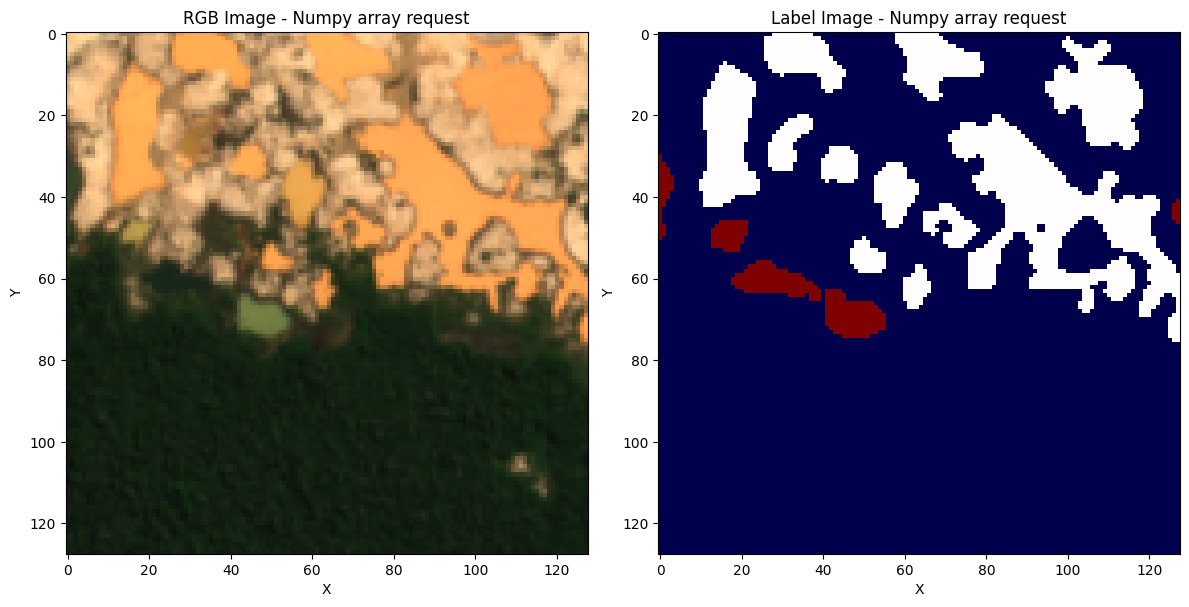

In [28]:
# Create the figure and subgraphs
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the RGB image on the first subgraph
display_array_rgb = rfn.structured_to_unstructured(ExamplePatch[['B4_normalized', 'B3_normalized', 'B2_normalized']]) * 6
axs[0].imshow(display_array_rgb)
axs[0].set_title('RGB Image - Numpy array request')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Plot the label image on the second subgraph
display_array_label = rfn.structured_to_unstructured(ExamplePatch[['class']])
axs[1].imshow(display_array_label, cmap='seismic')
axs[1].set_title('Label Image - Numpy array request')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()

# 4. Benchmark data import

In [14]:
# TF Record only
'''
def parse_example(request_array):
    # Define the structure of our TF Record
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'num_bands': tf.io.FixedLenFeature([], tf.int64),
        'patch': tf.io.VarLenFeature(tf.float32)
    }

    # Define the structure of our TF Record
    parsed_example = tf.io.parse_single_example(request_array, feature_description)

    # Gets the attributes and rebuilds the structured array
    height = tf.cast(parsed_example['height'], tf.int64)
    width = tf.cast(parsed_example['width'], tf.int64)
    num_bands = tf.cast(parsed_example['num_bands'], tf.int64)
    flattened_patch = tf.sparse.to_dense(parsed_example['patch'])

    # Rebuild the structured array
    patch_parse = tf.reshape(flattened_patch, (height, width, num_bands))
    bands_parse = patch_parse[:,:,:len(BANDS)]
    label_parse = patch_parse[:,:,len(BANDS):]

    return bands_parse, label_parse

'''

"\ndef parse_example(request_array):\n    # Define the structure of our TF Record\n    feature_description = {\n        'height': tf.io.FixedLenFeature([], tf.int64),\n        'width': tf.io.FixedLenFeature([], tf.int64),\n        'num_bands': tf.io.FixedLenFeature([], tf.int64),\n        'patch': tf.io.VarLenFeature(tf.float32)\n    }\n\n    # Define the structure of our TF Record\n    parsed_example = tf.io.parse_single_example(request_array, feature_description)\n\n    # Gets the attributes and rebuilds the structured array\n    height = tf.cast(parsed_example['height'], tf.int64)\n    width = tf.cast(parsed_example['width'], tf.int64)\n    num_bands = tf.cast(parsed_example['num_bands'], tf.int64)\n    flattened_patch = tf.sparse.to_dense(parsed_example['patch'])\n\n    # Rebuild the structured array\n    patch_parse = tf.reshape(flattened_patch, (height, width, num_bands))\n    bands_parse = patch_parse[:,:,:len(BANDS)]\n    label_parse = patch_parse[:,:,len(BANDS):]\n\n    return

In [15]:
# Bucket name
bucket_name = "gs://mining-ponds-dataset/"

# Feature names
BANDS = ['B2_normalized', 'B3_normalized', 'B4_normalized', 'B5_normalized', 'B6_normalized',
         'B7_normalized', 'B8_normalized', 'B8A_normalized', 'B11_normalized', 'B12_normalized']

LABEL = 'class'

# Input stack.
FEATURE_NAMES = BANDS + [LABEL]

# Import Patches in TFRecord or NPY
training_bucket_list = !gsutil ls gs://mining-ponds-dataset/training*
validation_bucket_list = !gsutil ls gs://mining-ponds-dataset/validation*
testing_bucket_list = !gsutil ls gs://mining-ponds-dataset/testing*

training_all_patches = []
validation_all_patches = []
testing_all_patches = []

##############################################
# TF Record only
'''
for tfrecord_file in training_bucket_list:
    print("Loading TF Record:", tfrecord_file)
    # Loading TF Record and parse
    dataset = tf.data.TFRecordDataset(tfrecord_file, compression_type='GZIP')
    parsed_dataset = dataset.map(parse_example, num_parallel_calls=5)

    for patch in parsed_dataset:
        # Add each patch to the list
        training_all_patches.append(patch)

'''
# Function to load a numpy file from a bucket
def load_numpy_file(file_path):
    patch_path = BytesIO(file_io.read_file_to_string(file_path, binary_mode=True))
    dataset = np.load(patch_path)
    print("Loading TF Record:", file_path)
    return dataset

# Load numpy files in parallel
with ThreadPoolExecutor(max_workers=8) as executor:
    # Load files in parallel using ThreadPoolExecutor
    futures = [executor.submit(load_numpy_file, file_path) for file_path in training_bucket_list]
    # Wait for all loads to be completed
    results = [future.result() for future in futures]
    training_all_patches.extend(results)

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(load_numpy_file, file_path) for file_path in validation_bucket_list]
    results = [future.result() for future in futures]
    validation_all_patches.extend(results)

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(load_numpy_file, file_path) for file_path in testing_bucket_list]
    results = [future.result() for future in futures]
    testing_all_patches.extend(results)


Loading TF Record: Loading TF Record: gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_100_0.npy
Loading TF Record: gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_101_0.npy
gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_0_0.npy
Loading TF Record:Loading TF Record: gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_103_0.npy
Loading TF Record: gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_104_0.npy
 gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_102_0.npy
Loading TF Record:Loading TF Record: gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_105_0.npy
 gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_108_0.npy
Loading TF Record: gs://mining-ponds-dataset/training_20230802T145731_20230802T150413_T19LCF_107_0.npy
Loading TF Record: gs://mining-ponds-dataset/training_20230802T145731_20230

In [16]:
print("Training: ", len(training_all_patches))
print("Validation: ", len(validation_all_patches))
print("Testing: ", len(testing_all_patches))

Training:  434
Validation:  107
Testing:  49


# 5. Benchmark data visualization

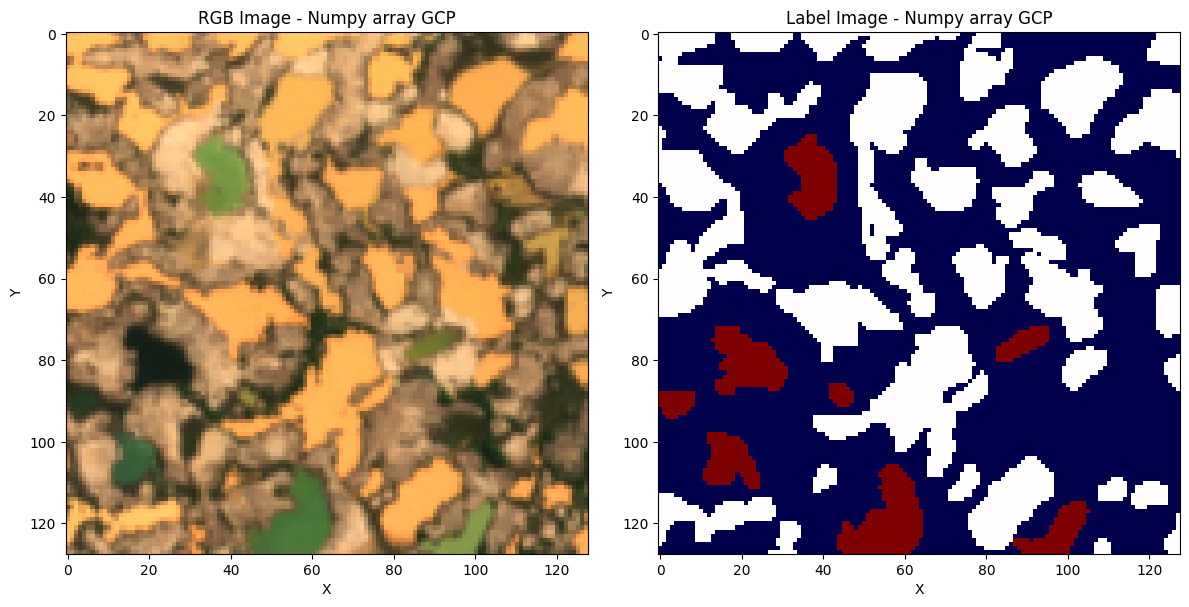

In [17]:
ExamplePatch2 = training_all_patches[50]

# Create the figure and subgraphs
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the RGB image on the first subgraph
display_array_rgb = rfn.structured_to_unstructured(ExamplePatch2[['B4_normalized', 'B3_normalized', 'B2_normalized']]) * 6
axs[0].imshow(display_array_rgb)
axs[0].set_title('RGB Image - Numpy array GCP')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Plot the label image on the second subgraph
display_array_label = rfn.structured_to_unstructured(ExamplePatch2[['class']])
axs[1].imshow(display_array_label, cmap='seismic')
axs[1].set_title('Label Image - Numpy array GCP')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()

# 6. Model training

## 6.1. Define required variables

In [ ]:
# We will install the AI Platform library
!pip install -U google-cloud-aiplatform
from google.cloud import aiplatform

In [81]:
# Bucket name
BUCKET = "gs://mining-ponds-dataset/"

# Region
REGION = 'us-central1'
# Trained model output locations
OUTPUT_DIR = BUCKET
EEIFIED_DIR = BUCKET

# Name of package containing training code
PACKAGE_PATH = 'mining_ponds_demo_package'
# Name of the hosted model and endpoint
MODEL_NAME = 'mining_ponds_model'
ENDPOINT_NAME = 'mining_ponds_model_endpoint'

# A container image that can run the hosted model.
CONTAINER_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest'

# Image scale and patch size
SCALE = 10
PATCH_SIZE = 128
KERNEL_SHAPE = [PATCH_SIZE, PATCH_SIZE]

# Model parameters
BATCH_SIZE = 16
EPOCHS = 40
BUFFER_SIZE = 2048

# Feature names
BANDS = ['B2_normalized', 'B3_normalized', 'B4_normalized', 'B5_normalized', 'B6_normalized',
         'B7_normalized', 'B8_normalized', 'B8A_normalized', 'B11_normalized', 'B12_normalized']

LABEL = 'class'

# Input stack.
FEATURE_NAMES = BANDS + [LABEL]

COLUMNS = [
  tf.io.FixedLenFeature(shape=[PATCH_SIZE, PATCH_SIZE], dtype=tf.float32)
  for k in FEATURE_NAMES
]
FEATURES_DICT = dict(zip(FEATURE_NAMES, COLUMNS))

CLASSIFICATIONS = {
    "Active_mining":              "#FFFF00",
    "Inactive_mining":            "#008000",
    "Other":                      "#9b9b9b",
}

NUM_CLASSES = len(CLASSIFICATIONS)

ATTRIBUTION = '© SERVIR AMAZONIA - 2023'

## 6.2. Data estructuration

In [37]:
print(type(training_all_patches[1]))
print(training_all_patches[1].shape)

<class 'numpy.ndarray'>
(128, 128)


In [38]:
# Apply the function to all elements using list
unstructured_training_all_patches = [rfn.structured_to_unstructured(numpy_array) for numpy_array in training_all_patches]
unstructured_validation_all_patches = [rfn.structured_to_unstructured(numpy_array) for numpy_array in validation_all_patches]
unstructured_testing_all_patches = [rfn.structured_to_unstructured(numpy_array) for numpy_array in testing_all_patches]

In [39]:
unstructured_training_all_patches[0].shape

(128, 128, 11)

In [40]:
# Apply the function to all elements using list
processed_training_all_patches = [[numpy_array[:, :, :len(BANDS)], numpy_array[:, :, len(BANDS):]] for numpy_array in unstructured_training_all_patches]
processed_validation_all_patches = [[numpy_array[:, :, :len(BANDS)], numpy_array[:, :, len(BANDS):]] for numpy_array in unstructured_validation_all_patches]
processed_testing_all_patches = [[numpy_array[:, :, :len(BANDS)], numpy_array[:, :, len(BANDS):]] for numpy_array in unstructured_testing_all_patches]

In [41]:
print(processed_training_all_patches[0][0].shape)
print(processed_training_all_patches[0][1].shape)

(128, 128, 10)
(128, 128, 1)


## 6.3. Data augmentation

In [42]:
def transform(features,labels):
    x = tf.random.uniform(())
    # flip image on horizontal axis
    if x < 0.12:
        feat = tf.image.flip_left_right(features)
        labl = tf.image.flip_left_right(labels)
    # flip image on vertical axis
    elif tf.math.logical_and(x >=0.12, x < 0.24):
        feat = tf.image.flip_up_down(features)
        labl = tf.image.flip_up_down(labels)
    # transpose image on bottom left corner
    elif tf.math.logical_and(x >=0.24, x < 0.36):
        feat = tf.image.flip_left_right(tf.image.flip_up_down(features))
        labl = tf.image.flip_left_right(tf.image.flip_up_down(labels))
    # rotate to the left 90 degrees
    elif tf.math.logical_and(x >=0.36, x < 0.48):
        feat = tf.image.rot90(features,k=1)
        labl = tf.image.rot90(labels,k=1)
    # rotate to the left 180 degrees
    elif tf.math.logical_and(x >=0.48, x < 0.60):
        feat = tf.image.rot90(features,k=2)
        labl = tf.image.rot90(labels,k=2)
    # rotate to the left 270 degrees
    elif tf.math.logical_and(x >=0.60, x < 0.72):
        feat = tf.image.rot90(features,k=3)
        labl = tf.image.rot90(labels,k=3)
    # transpose image on bottom right corner
    elif tf.math.logical_and(x >=0.72, x < 0.84):
        feat = tf.image.flip_left_right(tf.image.rot90(features,k=2))
        labl = tf.image.flip_left_right(tf.image.rot90(labels,k=2))
    else:
        feat = features
        labl = labels

    return feat,labl

In [43]:
# Apply the function to all elements using list
# Only Training data
transformed_training_all_patches = [transform(numpy_array[0], numpy_array[1]) for numpy_array in processed_training_all_patches]
transformed_validation_all_patches = processed_validation_all_patches
transformed_testing_all_patches = processed_testing_all_patches

print(transformed_training_all_patches[0][0].shape)
print(transformed_training_all_patches[0][1].shape)

(128, 128, 10)
(128, 128, 1)


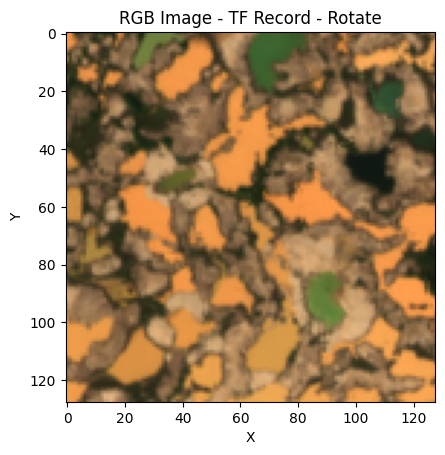

In [44]:
# Extracts bands B4, B3 and B2
band_4 = transformed_training_all_patches[50][0][:, :, 2]  # Band 4
band_3 = transformed_training_all_patches[50][0][:, :, 1] # Band 3
band_2 = transformed_training_all_patches[50][0][:, :, 0]  # Band 2

rgb_image = np.stack((band_4, band_3, band_2), axis=-1)*5

# Displays the RGB image
plt.imshow(rgb_image)
plt.title('RGB Image - TF Record - Rotate')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## 6.4. One hot encoding

In [45]:
from keras.utils import to_categorical

# Apply the function to all elements using list
onehot_training_all_patches = [[numpy_array[0], to_categorical(numpy_array[1] , num_classes= NUM_CLASSES)] for numpy_array in transformed_training_all_patches]
onehot_validation_all_patches = [[numpy_array[0], to_categorical(numpy_array[1] , num_classes= NUM_CLASSES)] for numpy_array in transformed_validation_all_patches]
onehot_testing_all_patches = [[numpy_array[0], to_categorical(numpy_array[1] , num_classes= NUM_CLASSES)] for numpy_array in transformed_testing_all_patches]

#onehot_training_all_patches = transformed_training_all_patches
#onehot_validation_all_patches = transformed_validation_all_patches
#onehot_testing_all_patches = transformed_testing_all_patches

print(onehot_training_all_patches[0][0].shape)
print(onehot_training_all_patches[0][1].shape)

(128, 128, 10)
(128, 128, 3)


## 6.5. Stack dataset

In [79]:
x_training_dataset = np.stack([numpy_array[0] for numpy_array in onehot_training_all_patches], axis=0)
x_validation_dataset = np.stack([numpy_array[0] for numpy_array in onehot_validation_all_patches], axis=0)
x_testing_dataset = np.stack([numpy_array[0] for numpy_array in onehot_testing_all_patches], axis=0)

y_training_dataset = np.stack([numpy_array[1] for numpy_array in onehot_training_all_patches], axis=0)
y_validation_dataset = np.stack([numpy_array[1] for numpy_array in onehot_validation_all_patches], axis=0)
y_testing_dataset = np.stack([numpy_array[1] for numpy_array in onehot_testing_all_patches], axis=0)

print(x_training_dataset.shape)
print(y_training_dataset.shape)
print(x_validation_dataset.shape)
print(y_validation_dataset.shape)
print(x_testing_dataset.shape)
print(y_testing_dataset.shape)

(434, 128, 128, 10)
(434, 128, 128, 3)
(107, 128, 128, 10)
(107, 128, 128, 3)
(49, 128, 128, 10)
(49, 128, 128, 3)


In [80]:
training_size = x_training_dataset.shape[0]
validation_size = x_validation_dataset.shape[0]
testing_size = x_testing_dataset.shape[0]

print(training_size)
print(validation_size )
print(testing_size)

434
107
49


## 6.6. Model architecture

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate, BatchNormalization, Activation

def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D((2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = UpSampling2D((2, 2))(input_tensor)
    decoder = concatenate([concat_tensor, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    return decoder

def get_model():

    inputs = tf.keras.Input(shape=[PATCH_SIZE, PATCH_SIZE, len(BANDS)])

    # Encoder
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
    center = conv_block(encoder4_pool, 1024)

    # Decoder
    decoder4 = decoder_block(center, encoder4, 512)
    decoder3 = decoder_block(decoder4, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)

    outputs = Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(decoder0)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [48]:
from tensorflow.keras import layers

def get_model2(input_depth, num_classes):
    inputs = keras.Input(shape=[128, 128, input_depth], name='array')

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax", padding="same")(x)

    return keras.Model(inputs, outputs)

In [49]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, Add
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
  x = Conv2D(filters, size, strides=strides, padding=padding)(x)
  x = BatchNormalization()(x)
  if activation == True:
      x = Activation('relu')(x)
  return x

def residual_block(blockInput, num_filters=16):
  x = Activation('relu')(blockInput)
  x = BatchNormalization()(x)
  x = convolution_block(x, num_filters, (3,3) )
  x = convolution_block(x, num_filters, (3,3), activation=False)
  x = Add()([x, blockInput])
  return x

# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
# 101 -> 50
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
  conv1 = residual_block(conv1,start_neurons * 1)
  conv1 = residual_block(conv1,start_neurons * 1)
  conv1 = Activation('relu')(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)
  pool1 = Dropout(DropoutRatio/2)(pool1)

# 50 -> 25
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
  conv2 = residual_block(conv2,start_neurons * 2)
  conv2 = residual_block(conv2,start_neurons * 2)
  conv2 = Activation('relu')(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)
  pool2 = Dropout(DropoutRatio)(pool2)

# 25 -> 12
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
  conv3 = residual_block(conv3,start_neurons * 4)
  conv3 = residual_block(conv3,start_neurons * 4)
  conv3 = Activation('relu')(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)
  pool3 = Dropout(DropoutRatio)(pool3)

# 12 -> 6
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
  conv4 = residual_block(conv4,start_neurons * 8)
  conv4 = residual_block(conv4,start_neurons * 8)
  conv4 = Activation('relu')(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)
  pool4 = Dropout(DropoutRatio)(pool4)

# Middle
  convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
  convm = residual_block(convm,start_neurons * 16)
  convm = residual_block(convm,start_neurons * 16)
  convm = Activation('relu')(convm)

# 6 -> 12
  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  uconv4 = Dropout(DropoutRatio)(uconv4)

  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
  uconv4 = residual_block(uconv4,start_neurons * 8)
  uconv4 = residual_block(uconv4,start_neurons * 8)
  uconv4 = Activation('relu')(uconv4)

# 12 -> 25
  deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
  #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  uconv3 = Dropout(DropoutRatio)(uconv3)

  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
  uconv3 = residual_block(uconv3,start_neurons * 4)
  uconv3 = residual_block(uconv3,start_neurons * 4)
  uconv3 = Activation('relu')(uconv3)

# 25 -> 50
  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])

  uconv2 = Dropout(DropoutRatio)(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
  uconv2 = residual_block(uconv2,start_neurons * 2)
  uconv2 = residual_block(uconv2,start_neurons * 2)
  uconv2 = Activation('relu')(uconv2)

# 50 -> 101
  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
  uconv1 = concatenate([deconv1, conv1])

  uconv1 = Dropout(DropoutRatio)(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
  uconv1 = residual_block(uconv1,start_neurons * 1)
  uconv1 = residual_block(uconv1,start_neurons * 1)
  uconv1 = Activation('relu')(uconv1)

  uconv1 = Dropout(DropoutRatio/2)(uconv1)
  output_layer = Conv2D(NUM_CLASSES, (1,1), padding="same", activation="softmax")(uconv1)

  return output_layer

In [59]:
inputs=tf.keras.layers.Input((128,128,10))
s=inputs

outputs=build_model(s,16, DropoutRatio = 0.5)
model4 = tf.keras.Model(inputs=[inputs], outputs=[outputs])

lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001,
    decay_steps = int(402/BATCH_SIZE)*10,
    decay_rate = 0.95)

OPTIMIZER = tf.keras.optimizers.Adam(
    learning_rate = lr_decay
)

model4.compile(optimizer = tf.keras.optimizers.get(OPTIMIZER),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

#checkpointer = tf.keras.callbacks.ModelCheckpoint('model1_for_segmentation.h5', verbose=1, save_best_only=True)
#callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy'),checkpointer]
results = model4.fit(
    x = x_training_dataset,
    y = y_training_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (x_validation_dataset, y_validation_dataset))


Epoch 1/40
28/28 [==============================] - 41s 205ms/step - loss: 1.2990 - accuracy: 0.5125 - val_loss: 0.9447 - val_accuracy: 0.7565
Epoch 2/40
28/28 [==============================] - 4s 154ms/step - loss: 0.7293 - accuracy: 0.7285 - val_loss: 0.7345 - val_accuracy: 0.7566
Epoch 3/40
28/28 [==============================] - 4s 153ms/step - loss: 0.4885 - accuracy: 0.8299 - val_loss: 0.6679 - val_accuracy: 0.7566
Epoch 4/40
28/28 [==============================] - 4s 155ms/step - loss: 0.3826 - accuracy: 0.8697 - val_loss: 0.7902 - val_accuracy: 0.7566
Epoch 5/40
28/28 [==============================] - 4s 152ms/step - loss: 0.3307 - accuracy: 0.8875 - val_loss: 1.0502 - val_accuracy: 0.7566
Epoch 6/40
28/28 [==============================] - 4s 153ms/step - loss: 0.2958 - accuracy: 0.8997 - val_loss: 1.4257 - val_accuracy: 0.7566
Epoch 7/40
28/28 [==============================] - 4s 161ms/step - loss: 0.2775 - accuracy: 0.9058 - val_loss: 1.7890 - val_accuracy: 0.7566
Epoch

In [65]:
evaluate = model4.evaluate(
    x = x_testing_dataset,
    y = y_testing_dataset,
    verbose = 1,
    steps = testing_size
)

49/49 [==============================] - 2s 10ms/step - loss: 0.1383 - accuracy: 0.9493


In [68]:
predict = model4.predict(
    x = x_testing_dataset,
    verbose = 1,
    steps = testing_size
)

49/49 [==============================] - 1s 8ms/step


In [71]:
predict.shape

(49, 128, 128, 3)

In [83]:
x_testing_dataset.shape

(49, 128, 128, 10)

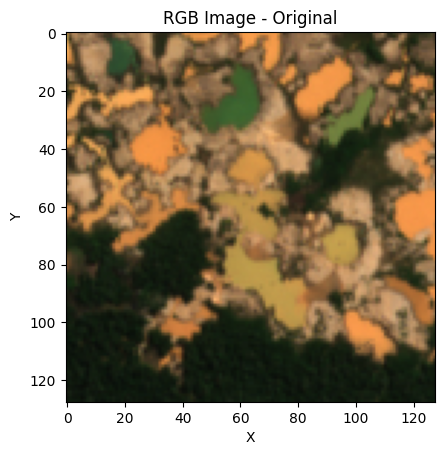

In [94]:
# Extracts bands B4, B3 and B2
band_4 = x_testing_dataset[15][:, :, 2]  # Band 4
band_3 = x_testing_dataset[15][:, :, 1] # Band 3
band_2 = x_testing_dataset[15][:, :, 0]  # Band 2

rgb_image = np.stack((band_4, band_3, band_2), axis=-1)*5

# Displays the RGB image
plt.imshow(rgb_image)
plt.title('RGB Image - Original')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

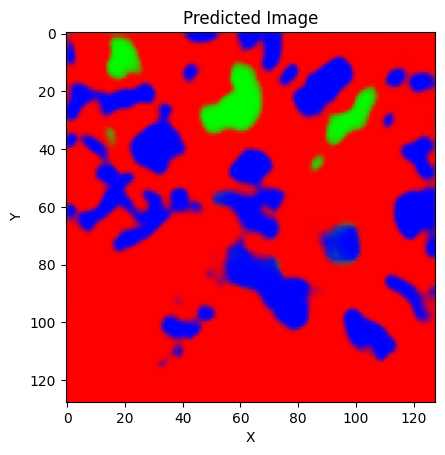

In [97]:
# Extracts bands
r = predict[15][:, :, 0]
g = predict[15][:, :, 2]
b = predict[15][:, :, 1]

rgb_image = np.stack((r, g, b), axis=-1)

# Displays the RGB image
plt.imshow(rgb_image)
plt.title('Predicted Image')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()